In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


# Link para a pasta do dataset: 
https://drive.google.com/drive/folders/15OS8-Ic3cFtRvv_nI_x03lkQxzqksCOz?usp=sharing



In [2]:
import os

import numpy as np

from matplotlib import pyplot

%matplotlib inline

import torch

from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

from torch import nn
from torch import optim

import time

# Função para testar a disponibilidade de uma GPU

In [3]:
def testar_gpu():
	train_on_gpu = torch.cuda.is_available() 
	if train_on_gpu: 
		device = torch.device('cuda') 
		print("Treinando na GPU") 
	else: 
		device = torch.device('cpu') 
		print("GPU indisponível, treinando na CPU")
	return device

device = testar_gpu()

Treinando na GPU


# Abrindo as imagens do dataset e convertendo-as para tensores de dimensão 224x224

In [4]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
data = ImageFolder('/content/drive/My Drive/DesafioFinal/dataset', transform=transform)

In [5]:
print('Total de imagens no dataset:', len(data))
percentage = 60 
n_treino = round(len(data)* (percentage/100))

n_teste = round(len(data)* (100 - percentage)/(2*100)) 
n_valid = len(data) - n_treino - n_teste

print('nº de imagens para treino: {:}'.format(n_treino) +'; nº de imagens para teste: {:}'.format(n_teste) +'; nº de imagens para validação: {:}'.format(n_valid) + '.')
data_train, data_test, data_valid = random_split(data, [n_treino, n_teste, n_valid], generator=torch.Generator().manual_seed(42))

Total de imagens no dataset: 4435
nº de imagens para treino: 2661; nº de imagens para teste: 887; nº de imagens para validação: 887.


In [6]:
batch_size = 100 
loader_train, loader_test, loader_valid = DataLoader(data_train, batch_size=batch_size), DataLoader(data_test, batch_size=1), DataLoader(data_valid, batch_size=1)

# Importando uma ResNet34

Como este é um problema relativamente simples, não foi necessário utilizar um modelo complexo para alcançar bons resultados. Assim, os parâmetros e os valores dos hiperparâmetros escolhidos também foram simples e tradicionais. 

Abaixo descrevo as decisões tomadas na escolha dos parâmetros e dos hiperparâmetros:


**ResNet**

Escolhi a ResNet34 por ser a que se encaixa melhor neste tipo de problema. Ela não é tão simples quanto a ResNet18 e qualquer uma das ResNets maiores que a ResNet34 trariam uma complexidade desnecessária para o modelo.  


**Função de perda**

Utilizei a NLLLoss porque, além de ser uma das funções que eu mais estou familiarizado, o funcionamento dela é simples e eficaz.


**Otimizador**

Escolhi um SGD com momentum de 0.9 e weight decay de 0.005. Fiz essa escolha por me sentir mais confortável e seguro na utilização de um SGD do que dos outros otimizadores, no momento da implementação deste modelo. 


**Learning Rate**

O valor do lr foi de 0.005, o que é um valor bastante eficiente. Levando em conta o momentum do SGD, é possível alcançar ótimos resultados numa quantidade baixa de epochs.


**Epochs**

Um total de 15 epochs foi suficiente para alcançar um resultado satisfatório. Seria possível reduzir esse valor até para 10 epochs sem prejudicar muito o resultado do modelo, mas como o objetivo era alcançar a maior acurácia possível, decidi utilizar 15 epochs.





In [7]:
def importNN():

    model=0
    classifier = 0 

    model = models.resnet34(pretrained=True)

    for param in model.parameters():
          param.requires_grad = False

          classifier = nn.Sequential(nn.Linear(512,256),
                                      nn.ReLU(),
                                      nn.Dropout(p=0.2),
                                      nn.Linear(256,6),
                                      nn.LogSoftmax(dim=1))
    
    model.fc = classifier

    return model

In [8]:
model = importNN().to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [9]:
def define(model, lr):

    criterion = nn.NLLLoss()

    optimizer = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9, weight_decay=0.005)

    return optimizer, criterion

# Treinando o modelo.

In [10]:
def train_test(model, loader_train, loader_test):

  train_loss,test_loss,acc =0,0,0 

  model.train()
  for imagem_treino,label_treino in loader_train:

    loss = 0
    imagem_treino, label_treino = imagem_treino.float().to(device), label_treino.to(device)
    outputs = model(imagem_treino)
    loss = criterion(outputs, label_treino.float().long())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss
	
  train_loss = train_loss/len(loader_train)

  model.eval()
  correct = 0
  total = 0
  test_loss = 0
	
  with torch.no_grad():
	  for imagem_teste, label_teste in loader_test:

		  imagem_teste, label_teste = imagem_teste.float().to(device), label_teste.to(device)
		  outputs_test = model(imagem_teste)
	 
		  _,previsao = torch.max(outputs_test, dim = 1)
		  test_loss += criterion(outputs_test, label_teste.long())
		  total = total + 1
			
		  if previsao == label_teste: 
		    correct = correct + 1
		
	  test_loss = test_loss/len(loader_test)

	  acc = (correct/total)*100
	 

  return train_loss, test_loss, acc

In [15]:
START = time.time()

list_train_loss = []
list_test_loss = []
list_acc = []
time1epoch = 0

lr = 0.005 
epochs = 15 
optimizer, criterion = define(model, lr)

for epoch in range(1, epochs+1):
  start = time.time()
  train_loss, test_loss, acc = train_test(model, loader_train, loader_test)
  end = time.time()

  list_train_loss.append(train_loss), list_test_loss.append(test_loss), list_acc.append(acc)

  Time = end - start
  if epoch == 1:
    time1epoch = Time

  if epoch < 10:
    print('Epoch: ', epoch ,' loss: {:.4f}'.format(test_loss.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
  else:
    print('Epoch:', epoch ,' loss: {:.4f}'.format(test_loss.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
END = time.time()

print()
TIME = (END - START) - time1epoch
print('\n Time spent during training, excluding first epoch: {:.2f}'.format(TIME), 'seconds.')		

Epoch:  1  loss: 0.1842  Accuracy: 97.41  Time spent this epoch: 839.80 seconds.
Epoch:  2  loss: 0.0942  Accuracy: 98.76  Time spent this epoch: 26.79 seconds.
Epoch:  3  loss: 0.0741  Accuracy: 98.99  Time spent this epoch: 26.74 seconds.
Epoch:  4  loss: 0.0646  Accuracy: 98.87  Time spent this epoch: 26.76 seconds.
Epoch:  5  loss: 0.0622  Accuracy: 98.76  Time spent this epoch: 27.51 seconds.
Epoch:  6  loss: 0.0567  Accuracy: 98.99  Time spent this epoch: 26.62 seconds.
Epoch:  7  loss: 0.0518  Accuracy: 98.99  Time spent this epoch: 26.64 seconds.
Epoch:  8  loss: 0.0481  Accuracy: 98.99  Time spent this epoch: 26.71 seconds.
Epoch:  9  loss: 0.0459  Accuracy: 98.99  Time spent this epoch: 26.59 seconds.
Epoch: 10  loss: 0.0415  Accuracy: 98.99  Time spent this epoch: 26.58 seconds.
Epoch: 11  loss: 0.0406  Accuracy: 98.99  Time spent this epoch: 27.13 seconds.
Epoch: 12  loss: 0.0387  Accuracy: 98.99  Time spent this epoch: 26.71 seconds.
Epoch: 13  loss: 0.0375  Accuracy: 98.9

# Plot dos gráficos de perda e acurácia em cada epoch.

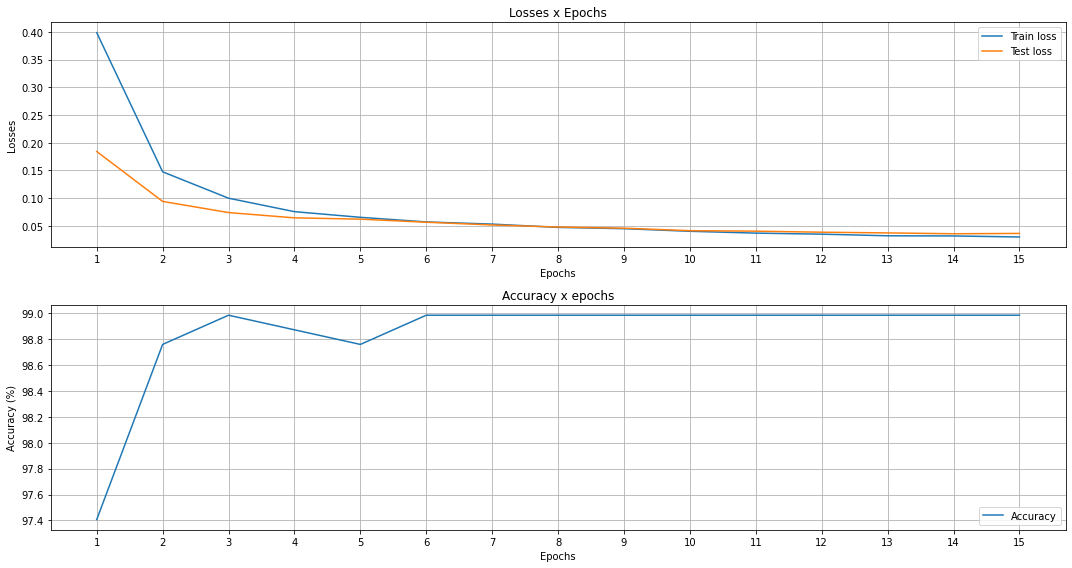

In [16]:
fig, axs = pyplot.subplots(2, figsize=(15,8))
axs[0].plot(range(1, epochs+1), list_train_loss,label="Train loss") 
axs[0].plot(range(1, epochs+1), list_test_loss, label="Test loss")
axs[0].set(xticks=range(1, epochs+1))
axs[0].set_title('Losses x Epochs') 
axs[0].set(xlabel='Epochs') 
axs[0].set(ylabel='Losses') 
axs[0].legend() 
axs[0].grid(True) 

axs[1].plot(range(1, epochs+1), list_acc, label='Accuracy') 
axs[1].set(xticks=range(1, epochs+1))
axs[1].set_title('Accuracy x epochs') 
axs[1].set(xlabel='Epochs') 
axs[1].set(ylabel='Accuracy (%)') 
axs[1].legend(loc='lower right')
axs[1].grid(True) 

pyplot.tight_layout()


# Testando o modelo no dataset de teste e obtendo os resultados.

In [18]:
total = 0
correct = 0
loss_valid = 0

for imagem_valid, label_valid in loader_valid:

	loss_v = 0

	imagem_valid, label_valid = imagem_valid.float().to(device), label_valid.to(device)
	outputs_valid = model(imagem_valid)
	_, previsao = torch.max(outputs_valid, dim = 1)
	loss_v = criterion (outputs_valid, label_valid.long())
	total = total + 1 
	if previsao == label_valid: 
		correct = correct + 1 
	loss_valid += loss_v

loss_valid = loss_valid/len(loader_valid)
accuracy = (correct/total)*100 

print('A acurácia obtida foi de: {:.2f}'.format(accuracy) + '%.')
print()
print('O erro médio obtido foi de: {:.4f}'.format(loss_valid))
print()
print('O tempo gasto durante o treinamento, excluindo a primeira época, foi de: {:.2f}'.format(TIME), 'segundos.')
print()


A acurácia obtida foi de: 98.87%.

O erro médio obtido foi de: 0.0488

O tempo gasto durante o treinamento, excluindo a primeira época, foi de: 374.79 segundos.



# Salvando o modelo treinado.

In [19]:
torch.save(model, '/content/drive/My Drive/DesafioFinal/model.pt')

# Implementação da função Predict

O objetivo desta função é receber uma imagem de qualquer um dos veículos listados no enunciado do desafio e retornar um número de 0 à 5, sendo:



*   **0** = Ferrari Enzo
*   **1** = Fiat Uno Way
*   **2** = Hummer H1
*   **3** = Kawasaki Ninja
*   **4** = Volkswagen Worker
*   **5** = Imagem de estrada vazia

In [20]:
from PIL import Image
from torch.autograd import Variable

In [21]:
def predict(imagem, modelo):
  modelo_treinado = torch.load(modelo)
  loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

  def image_loader(image_name):

    image = Image.open(image_name)
    image = loader(image).float().to(device)
    image = Variable(image, requires_grad=True)
    image.unsqueeze(0)
    return image.cuda()

  image = image_loader(imagem)

  saida = modelo_treinado(image[None, ...])
  _, previsao = torch.max(saida, dim = 1)

  resultado = int(previsao.data[0])

  return resultado

# Exemplo de chamada da função predict

In [22]:
predict('/content/drive/My Drive/DesafioFinal/imgTeste/cHummer/humm.jpg', '/content/drive/My Drive/DesafioFinal/model.pt')

2